In [3]:
import sys
parentdir = ".."
sys.path.insert(0, parentdir)

import requests
from os import path
from tqdm.notebook import tqdm
import pandas as pd
import time

from metrics.WebResource import WebResource
from metrics.FAIRMetricsFactory import FAIRMetricsFactory
from metrics.AbstractFAIRMetrics import AbstractFAIRMetrics

/home/thomas/anaconda3/envs/fair-checker-env/lib/python3.8/site-packages/rdflib_jsonld/__init__.py:9: DeprecationWarning: The rdflib-jsonld package has been integrated into rdflib as of rdflib==6.0.1.  Please remove rdflib-jsonld from your project's dependencies.
  warnings.warn(
[WDM] - 

[WDM] - ====== WebDriver manager ======
[WDM] - Current google-chrome version is 96.0.4664
[WDM] - Get LATEST driver version for 96.0.4664
[WDM] - Driver [/home/thomas/.wdm/drivers/chromedriver/linux64/96.0.4664.45/chromedriver] found in cache


In [2]:
from rdflib import ConjunctiveGraph, Namespace, URIRef
from rdflib.namespace import RDF, RDFS

schema = Namespace("http://schema.org/")

In [3]:
TIMEOUT = (10, 300)
NB = '10000'

def pangaeaRestRequest():
    print("REST request to pangaea...")
    # rest request
    url = 'https://ws.pangaea.de/es/pangaea/panmd/_search?pretty&size=' + NB
    while True:
        try:
            response = requests.get(url, timeout=TIMEOUT)
            break
        except SSLError:
            time.sleep(5)
        except requests.exceptions.Timeout:
            time.sleep(5)

    return response

def pangaeaJsonParser(response):
    print("Parsing result...")
    json_response = response.json()

    dois_list = []
    for element in json_response["hits"]["hits"]:
        if "URI" in element["_source"].keys():
            doi = element["_source"]["URI"]
            dois_list.append(doi)
            
    print("Retrieved " + str(len(dois_list)) + " DOIs")
    return dois_list

In [4]:
response = pangaeaRestRequest()
dois_list = pangaeaJsonParser(response)

REST request to pangaea...
Parsing result...


In [5]:
import random
#sample_tool = random.choice(index.keys())

random.seed(10)

#samples = random.sample(list(index.items()), 1000)
samples_dois_list = random.sample(dois_list, 5000)

splitedSize = 500
samples_chunks = [samples_dois_list[x:x+splitedSize] for x in range(0, len(samples_dois_list), splitedSize)]

In [6]:
print(len(samples_dois_list))

5000


In [7]:
metrics_collection = []
metrics_collection.append(FAIRMetricsFactory.get_F1A(None))
metrics_collection.append(FAIRMetricsFactory.get_F1B(None))
metrics_collection.append(FAIRMetricsFactory.get_F2A(None))
#metrics_collection.append(FAIRMetricsFactory.get_F2B_weak(None))
metrics_collection.append(FAIRMetricsFactory.get_I1A(None))
metrics_collection.append(FAIRMetricsFactory.get_I1B(None))
metrics_collection.append(FAIRMetricsFactory.get_I2A(None))
metrics_collection.append(FAIRMetricsFactory.get_I2B(None))
metrics_collection.append(FAIRMetricsFactory.get_I3(None))
metrics_collection.append(FAIRMetricsFactory.get_R11(None))
metrics_collection.append(FAIRMetricsFactory.get_R12(None))
#metrics_collection.append(FAIRMetricsFactory.get_R13(None))

df_columns = ['ID']
for m in metrics_collection:
    #print(m.get_principle_tag())
    df_columns.append(m.get_principle_tag())

In [8]:
exec_time_df = pd.DataFrame(columns=df_columns)

def eval_metrics(web_res):
    metrics_collection = []
    metrics_collection.append(FAIRMetricsFactory.get_F1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_F2A(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_F2B_weak(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I1B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I2A(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I2B(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_I3(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R11(web_res))
    metrics_collection.append(FAIRMetricsFactory.get_R12(web_res))
#    metrics_collection.append(FAIRMetricsFactory.get_R13(web_res))
    
    row = {"ID":web_res.get_url()}
    row_time = {"ID":web_res.get_url()}
    for m in metrics_collection:
        ts1 = time.time()
        e = m.evaluate()
        duration = round((time.time() - ts1), 2)
        if e is not None:
            row[m.get_principle_tag()] = e.get_score()
            row_time[m.get_principle_tag()] = duration
    
    return row, row_time

In [9]:
#%%time

def mass_eval(samples):
    evals = []
    exec_time = []


    for sample in tqdm(samples):
        wr = WebResource(url=sample)
        row, row_time = eval_metrics(wr)
        evals.append(row)
        exec_time.append(row_time)
        
    
    return evals, exec_time

In [ ]:
import logging
logging.getLogger().setLevel(logging.ERROR)

i = 0
for c in tqdm(samples_chunks):
    i += 1
    df = pd.DataFrame()
    df_time = pd.DataFrame()
    
    evals, exec_time = mass_eval(c)
    df = pd.concat([df, pd.DataFrame.from_records(evals)])
    df_time = pd.concat([df_time, pd.DataFrame.from_records(exec_time)])
    
    df.to_csv("FC_results_PANGAEA_"+str(i)+".csv")
    df_time.to_csv("exec_time_PANGAEA_"+str(i)+".csv")

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

In [1]:
len(df)

NameError: name 'df' is not defined

In [ ]:
df_time

In [4]:
import glob

all_files = glob.glob("./FC_results_PANGAEA_*.csv")

li = []

for filename in tqdm(all_files):
    df = pd.read_csv(filename, index_col=None, header=0)
    li.append(df)
df = pd.concat(li, axis=0, ignore_index=True)

  0%|          | 0/9 [00:00<?, ?it/s]

In [5]:
from upsetplot import generate_counts, generate_samples, UpSet,plot
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 200 

In [6]:
from upsetplot import from_contents

F1B = df[((df["F1B"].astype(int) > 0))]["ID"]
F2A = df[((df["F2A"].astype(int) > 0))]["ID"]
#F2B = df[((df["F2B"].astype(int) > 0))]["ID"]

I1A = df[((df["I1A"].astype(int) > 0))]["ID"]
I1B = df[((df["I1B"].astype(int) > 0))]["ID"]

I2A = df[((df["I2A"].astype(int) > 0))]["ID"]
I2B = df[((df["I2B"].astype(int) > 0))]["ID"]

I3 = df[((df["I3"].astype(int) > 0))]["ID"]

R11 = df[((df["R1.1"].astype(int) > 0))]["ID"]
R12 = df[((df["R1.2"].astype(int) > 0))]["ID"]
#R13 = df[((df["R1.3"].astype(int) > 0))]["ID"]

df_upset = from_contents({'F1B': F1B, 
                          'F2A': F2A, 
#                          'F2B*': F2B,
                          'I1A': I1A, 
                          'I1B': I1B,
                          'I2A': I2A, 
                          'I2B': I2B,
                          'I3': I3, 
                          'R11': R11, 
                          'R12': R12,})
#                          'R13*': R13})
df_upset

id
F1B   F2A  I1A  I1B  I2A   I2B  I3   R11   R12                                                 
True  True True True False True True True  False         https://doi.org/10.1594/PANGAEA.932663
                                           False         https://doi.org/10.1594/PANGAEA.665784
                                           False         https://doi.org/10.1594/PANGAEA.255517
                                     False False         https://doi.org/10.1594/PANGAEA.831809
                                     True  False         https://doi.org/10.1594/PANGAEA.198891
...                                                                                         ...
                                           False         https://doi.org/10.1594/PANGAEA.853907
                                           False         https://doi.org/10.1594/PANGAEA.251642
                                           False         https://doi.org/10.1594/PANGAEA.321712
                                           False         https://doi.org/10.1594/PANGAEA.804187
False True True True False True True False False  https://doi.pangaea.de/10.1594/PANGAEA.897999

[4500 rows x 1 columns]

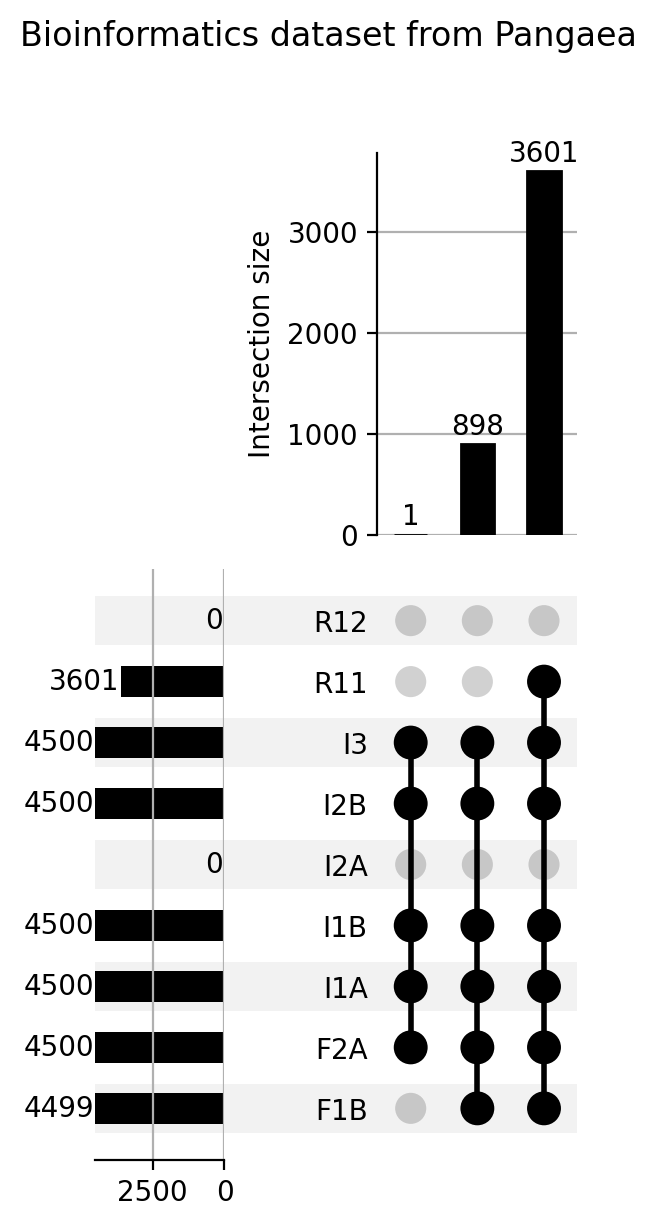

In [7]:
upset = UpSet(df_upset, subset_size='count', show_counts=True, sort_categories_by=None, orientation='horizontal')

#upset.style_subsets(present=["with_exome", "with_images"],
#                    facecolor="red")

params = {'legend.fontsize': 8}
with plt.rc_context(params):
    upset.plot()
plt.suptitle("Bioinformatics dataset from Pangaea")
plt.savefig('pangaea-no-F2B-no-R13.png', format="png")
plt.show()